#**TL;DR**

**Collaborators: Shoval Benjer, Adir Amar**

This project demonstrates clustering analysis on FIFA player data using Apache Spark. It includes steps to preprocess data, apply feature transformations, find optimal clustering parameters, and visualize clusters with PCA.




#**Setup**

**System Requirements:**

    Operating System: Linux-based environment (recommended for compatibility) or Windows with WSL2.

Software:
    Python 3.8+, Java 8 (OpenJDK 8), and Apache Spark.

Libraries:

    pyspark, kafka-python, threading, and json.

Environment Setup:

**Google Colab is Recommended for running the notebook.**

Local System: Ensure you have Apache Spark and Kafka installed with appropriate environment variables configured.


Description for Each Step:

      Install Java:
      This command installs the OpenJDK 8 runtime environment, a necessary dependency for running Apache Spark and Kafka. The -qq flag minimizes output during the installation process.

      Download Apache Spark:
      Downloads Apache Spark version 3.5.0 with Hadoop 3 compatibility from the official Apache archives. Spark is a distributed computing framework essential for big data processing tasks.

      Verify the Spark Download:
      Lists the downloaded Spark tarball to confirm that the file has been successfully downloaded.

      Extract the Spark Archive:
      Unpacks the Spark tarball to make the Spark distribution files accessible for configuration and usage.

      Move Spark to the Local Directory:
      Moves the extracted Spark directory to /usr/local/spark, setting a standard location for Spark installation, simplifying environment variable configuration.

      Download Apache Kafka:
      Downloads Apache Kafka version 3.5.1 (Scala version 2.13), a distributed event-streaming platform commonly used for real-time data pipelines and streaming applications.

      Verify the Kafka Download:
      Lists the downloaded Kafka tarball to ensure successful file retrieval.

      Extract the Kafka Archive:
      Unpacks the Kafka tarball to access its binaries and configuration files.

      Move Kafka to the Local Directory:
      Moves the extracted Kafka directory to /usr/local/kafka for organized setup and easier configuration.

      Set Environment Variables:
      Configures environment variables for Java, Spark, and Kafka to ensure their executables can be accessed system-wide. This includes updating the PATH variable for seamless command-line operations.

      Install Python Libraries:
      Installs pyspark for interacting with Spark using Python and kafka-python for Kafka integration within Python applications.

      Start Zookeeper:
      Launches Zookeeper, a centralized service used by Kafka for managing distributed systems. It provides configuration synchronization and group services for Kafka brokers.

      Start Kafka Broker:
      Starts the Kafka broker service, which handles message queuing, storage, and distribution to clients in a publish-subscribe model.

#Setup, and Load

In [1]:
"""
2) IMPORTS & SPARK SESSION
All required libraries, including Spark and matplotlib.
"""
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, col, regexp_replace
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName("FIFA_ClusteringClean").getOrCreate()

25/01/11 21:18:20 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
def load_data(file_path):
    """
    Loads the FIFA data from a CSV file into a Spark DataFrame.
    Parameters:
        file_path (str): The path to the CSV file.
    Returns:
        DataFrame: Spark DataFrame containing the FIFA data.
    """
    df = spark.read.option("header", True).option("inferSchema", True).csv(file_path)
    return df

In [3]:
def create_salary_column(df):
    """
    Cleans 'Wage' (e.g., '€565K') to create a numeric 'Salary' column.
     - Removes '€'
     - Removes 'K'
     - Casts to double
    Parameters:
        df (DataFrame): The source DataFrame with 'Wage' as string.
    Returns:
        DataFrame: A new DataFrame with an extra numeric 'Salary' column.
    """
    temp = df.withColumn("Salary", regexp_replace(col("Wage"), "€", ""))
    temp = temp.withColumn("Salary", regexp_replace(col("Salary"), "K", ""))
    temp = temp.withColumn("Salary", col("Salary").cast("double"))
    return temp


In [4]:
def create_value_column(df):
    """
    Cleans 'Value' (e.g., '€110.5M', '€405K', etc.) to make it numeric in the 'Value' column.
    Steps:
     - Removes '€'
     - Strips out weird null or non-ASCII chars
     - Handles 'M' (millions) or 'K' (thousands)
     - Overwrites the old 'Value' column with a numeric double
       (i.e., the column name stays 'Value', but now it's numeric)

    Parameters:
        df (DataFrame): Source DataFrame with 'Value' as string.
    Returns:
        DataFrame: A new DataFrame where 'Value' is numeric.
    """
    # Remove "€"
    temp = df.withColumn("Value", regexp_replace(col("Value"), "€", ""))

    # UDF to parse
    def parse_value(str_val):
        if not str_val:
            return None
        # Clean out non-ASCII
        cleaned = "".join(ch for ch in str_val.strip() if 32 <= ord(ch) <= 126)
        if not cleaned:
            return None
        cleaned = cleaned.upper()
        if cleaned.endswith("M"):
            try:
                return float(cleaned[:-1]) * 1e6
            except ValueError:
                return None
        elif cleaned.endswith("K"):
            try:
                return float(cleaned[:-1]) * 1e3
            except ValueError:
                return None
        else:
            try:
                return float(cleaned)
            except ValueError:
                return None

    parse_value_udf = F.udf(parse_value, DoubleType())
    temp = temp.withColumn("Value", parse_value_udf(col("Value")))
    return temp

In [5]:
def define_feature_management():
    """
    Defines the numeric columns we want to cluster on.
    We have:
        Age
        Overall
        Potential
        Salary (cleaned from 'Wage')
        Value  (cleaned from original 'Value')
    """
    return [
        ("Age", "Numerical", "Use as-is or scale", "Example: Age=31 -> scaled=0.45"),
        ("Overall", "Numerical", "Use as-is or scale", "Example: Overall=94 -> scaled=0.90"),
        ("Potential", "Numerical", "Use as-is or scale", "Example: Potential=94 -> scaled=0.90"),
        ("Salary", "Numerical", "Use as-is or scale", "Example: €565K -> 565 -> scaled=0.40"),
        ("Value", "Numerical", "Use as-is or scale", "Example: €110.5M -> 110500000 -> scaled=1.0"),
    ]

In [6]:
def print_feature_table(feature_management):
    """
    Prints a table that shows how each feature is being managed.
    """
    print("Column name | Feature type | Way to manage a feature | Example")
    for col_name, f_type, method, ex in feature_management:
        print(f"{col_name}\t{f_type}\t{method}\t{ex}")

In [7]:
def get_top_10_players_by_salary(df, salary_col="Salary"):
    """
    Returns the top 10 players by numeric salary in descending order.
    """
    top_10_df = df.orderBy(desc(salary_col)).limit(10)
    return top_10_df.collect()

In [8]:
def build_feature_pipeline(df, feature_cols, k):
    """
    Builds a pipeline:
      (1) VectorAssembler -> 'assembledFeatures'
      (2) StandardScaler  -> 'scaledFeatures'
      (3) KMeans -> 'clusterPrediction'
    Returns:
      - The fitted pipeline model
      - The transformed DataFrame (with cluster predictions)
    """
    # First, cache the filtered DataFrame to ensure consistent partitioning
    filtered_df = df.na.drop(subset=feature_cols).cache()

    # Repartition to ensure consistent partition sizes
    filtered_df = filtered_df.repartition(10)  # You can adjust the number based on your data size

    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="assembledFeatures"
    )

    scaler = StandardScaler(
        inputCol="assembledFeatures",
        outputCol="scaledFeatures",
        withMean=True,
        withStd=True
    )

    kmeans = KMeans(
        k=k,
        featuresCol="scaledFeatures",
        predictionCol="clusterPrediction",
        seed=42,
        maxIter=20  # Added to ensure convergence
    )

    pipeline = Pipeline(stages=[assembler, scaler, kmeans])

    try:
        model = pipeline.fit(filtered_df)
        transformed_df = model.transform(filtered_df)
        filtered_df.unpersist()  # Clean up cached data
        return model, transformed_df
    except Exception as e:
        filtered_df.unpersist()  # Ensure cleanup even if error occurs
        raise e

In [9]:
def find_optimal_clusters(df, feature_cols, min_k=2, max_k=8):
    """
    Loops over k in [min_k, max_k], builds pipeline, evaluates
    with Silhouette, picks best k.
    Returns (best_k, best_score).
    """
    best_k, best_score = None, -1

    # Cache the filtered DataFrame to avoid recomputing
    filtered_df = df.na.drop(subset=feature_cols).cache()
    filtered_df = filtered_df.repartition(10)  # Consistent partitioning

    evaluator = ClusteringEvaluator(
        predictionCol="clusterPrediction",
        featuresCol="scaledFeatures",
        metricName="silhouette"
    )

    try:
        for k in range(min_k, max_k + 1):
            print(f"Testing k={k}...")  # Added for debugging
            model, tdf = build_feature_pipeline(filtered_df, feature_cols, k)
            sil = evaluator.evaluate(tdf)
            print(f"Silhouette score for k={k}: {sil}")  # Added for debugging
            if sil > best_score:
                best_score = sil
                best_k = k

        filtered_df.unpersist()
        return best_k, best_score
    except Exception as e:
        filtered_df.unpersist()
        raise e

In [10]:
def cluster_and_report_top_10(df, feature_cols, k, top_10_players, id_col="Name"):
    """
    Builds the pipeline for given k, then checks how many of the top-10-salary
    players fall into each cluster.
    """
    from pyspark.sql.functions import count
    model, transformed_df = build_feature_pipeline(df, feature_cols, k)
    top_10_names = [row[id_col] for row in top_10_players]
    # Only the top-10 players
    filter_df = transformed_df.filter(col(id_col).isin(top_10_names))
    # Count how many appear in each cluster
    grouped = filter_df.groupBy("clusterPrediction").agg(count("*").alias("countTop10"))
    grouped = grouped.orderBy("clusterPrediction")
    return grouped.withColumnRenamed("clusterPrediction", "ClustersID")

In [11]:
def apply_pca(df, input_col, output_col, k):
    """
    Applies PCA to 'input_col' -> 'output_col' with k principal components.
    Returns new DataFrame with 'output_col'.
    """
    pca = PCA(k=k, inputCol=input_col, outputCol=output_col)
    pca_model = pca.fit(df)
    return pca_model.transform(df)

In [12]:
def plot_2d_clusters(df, x_col="pcaFeatures", cluster_col="pcaClusterPrediction",
                     top_10_ids=None, id_col="Name"):
    """
    Plots clusters in 2D space (first two PCA components).
    If top_10_ids is provided, highlight them in red with a label.
    """
    rows = df.select(x_col, cluster_col, id_col).collect()
    xs, ys, clusters, names = [], [], [], []
    for row in rows:
        vec = row[x_col]
        if vec and len(vec) >= 2:
            xs.append(vec[0])
            ys.append(vec[1])
        else:
            xs.append(0)
            ys.append(0)
        clusters.append(row[cluster_col])
        names.append(row[id_col])

    plt.figure(figsize=(8,6))
    sc = plt.scatter(xs, ys, c=clusters, cmap="viridis", alpha=0.5)
    plt.colorbar(sc, label="Cluster ID")
    plt.title("Clusters in 2D PCA Space")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")

    if top_10_ids:
        highlight = [r[id_col] for r in top_10_ids]
        for i, nm in enumerate(names):
            if nm in highlight:
                plt.scatter(xs[i], ys[i], c="red", marker="x", s=100)
                plt.text(xs[i]+0.3, ys[i], nm, fontsize=8, color="red")

    plt.show()

In [13]:
"""
MAIN EXECUTION
All steps from start to finish.
"""
file_path = "dataFIFA.csv"
df_fifa = load_data(file_path)

print("Preview Data:")
df_fifa.show(5)

# 1) Clean 'Wage' -> 'Salary'
df_fifa = create_salary_column(df_fifa)

# 2) Clean 'Value' -> numeric 'Value' (replaces the old string column with a numeric column of the same name)
df_fifa = create_value_column(df_fifa)

# Check columns to see that we have "Salary" and "Value" as doubles now
print("Columns:", df_fifa.columns)

Preview Data:
25/01/11 21:18:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/01/11 21:18:25 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , ID, Name, Age, Photo, Nationality, Flag, Overall, Potential, Club, Club Logo, Value, Wage, Special, Preferred Foot, International Reputation, Weak Foot, Skill Moves, Work Rate, Body Type, Real Face, Position, Jersey Number, Joined, Loaned From, Contract Valid Until, Height, Weight, LS, ST, RS, LW, LF, CF, RF, RW, LAM, CAM, RAM, LM, LCM, CM, RCM, RM, LWB, LDM, CDM, RDM, RWB, LB, LCB, CB, RCB, RB, Crossing, Finishing, HeadingAccuracy, ShortPassing, Volleys, Dribbling, Curve, FKAccuracy, LongPassing, BallControl, Acceleration, SprintSpeed, Agility, Reactions, Balance, ShotPower, Jumping, Stamina, Strength, LongShots, Aggression, Interceptions, Positioning, Vision, Penalties, Composure, Marking, StandingTa

Columns: ['_c0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause',

In [14]:
print("Identify top 10 players with the biggest Salary.")
top_10_players = get_top_10_players_by_salary(df_fifa, salary_col="Salary")
for row in top_10_players:
    print(row)

print("\nFeature Management Table:")
feature_info = define_feature_management()
print_feature_table(feature_info)

selected_features = [item[0] for item in feature_info]

print("\nFinding the optimal number of clusters via Silhouette.")

Identify top 10 players with the biggest Salary.


25/01/11 21:18:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , ID, Name, Age, Photo, Nationality, Flag, Overall, Potential, Club, Club Logo, Value, Wage, Special, Preferred Foot, International Reputation, Weak Foot, Skill Moves, Work Rate, Body Type, Real Face, Position, Jersey Number, Joined, Loaned From, Contract Valid Until, Height, Weight, LS, ST, RS, LW, LF, CF, RF, RW, LAM, CAM, RAM, LM, LCM, CM, RCM, RM, LWB, LDM, CDM, RDM, RWB, LB, LCB, CB, RCB, RB, Crossing, Finishing, HeadingAccuracy, ShortPassing, Volleys, Dribbling, Curve, FKAccuracy, LongPassing, BallControl, Acceleration, SprintSpeed, Agility, Reactions, Balance, ShotPower, Jumping, Stamina, Strength, LongShots, Aggression, Interceptions, Positioning, Vision, Penalties, Composure, Marking, StandingTackle, SlidingTackle, GKDiving, GKHandling, GKKicking, GKPositioning, GKReflexes, Release Clause
 Schema: _c0, ID, Name, Age, Photo, Nationality, Flag, Overall, Potential, Club, Club Logo, Value,

Row(_c0=0, ID=158023, Name='L. Messi', Age=31, Photo='https://cdn.sofifa.org/players/4/19/158023.png', Nationality='Argentina', Flag='https://cdn.sofifa.org/flags/52.png', Overall=94, Potential=94, Club='FC Barcelona', Club Logo='https://cdn.sofifa.org/teams/2/light/241.png', Value=110500000.0, Wage='€565K', Special=2202, Preferred Foot='Left', International Reputation=5, Weak Foot=4, Skill Moves=4, Work Rate='Medium/ Medium', Body Type='Messi', Real Face='Yes', Position='RF', Jersey Number=10, Joined='Jul 1, 2004', Loaned From=None, Contract Valid Until='2021', Height="5'7", Weight='159lbs', LS='88+2', ST='88+2', RS='88+2', LW='92+2', LF='93+2', CF='93+2', RF='93+2', RW='92+2', LAM='93+2', CAM='93+2', RAM='93+2', LM='91+2', LCM='84+2', CM='84+2', RCM='84+2', RM='91+2', LWB='64+2', LDM='61+2', CDM='61+2', RDM='61+2', RWB='64+2', LB='59+2', LCB='47+2', CB='47+2', RCB='47+2', RB='59+2', Crossing=84, Finishing=95, HeadingAccuracy=70, ShortPassing=90, Volleys=86, Dribbling=97, Curve=93, FK

Testing k=2...
25/01/11 21:18:29 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , ID, Name, Age, Photo, Nationality, Flag, Overall, Potential, Club, Club Logo, Value, Wage, Special, Preferred Foot, International Reputation, Weak Foot, Skill Moves, Work Rate, Body Type, Real Face, Position, Jersey Number, Joined, Loaned From, Contract Valid Until, Height, Weight, LS, ST, RS, LW, LF, CF, RF, RW, LAM, CAM, RAM, LM, LCM, CM, RCM, RM, LWB, LDM, CDM, RDM, RWB, LB, LCB, CB, RCB, RB, Crossing, Finishing, HeadingAccuracy, ShortPassing, Volleys, Dribbling, Curve, FKAccuracy, LongPassing, BallControl, Acceleration, SprintSpeed, Agility, Reactions, Balance, ShotPower, Jumping, Stamina, Strength, LongShots, Aggression, Interceptions, Positioning, Vision, Penalties, Composure, Marking, StandingTackle, SlidingTackle, GKDiving, GKHandling, GKKicking, GKPositioning, GKReflexes, Release Clause
 Schema: _c0, ID, Name, Age, Photo, Nationality, Flag, Overall, Potential, Club, Cl

Silhouette score for k=2: 0.6395052370797657
Testing k=3...
25/01/11 21:18:41 WARN CacheManager: Asked to cache already cached data.
Silhouette score for k=3: 0.4464197314416902
Testing k=4...
25/01/11 21:18:46 WARN CacheManager: Asked to cache already cached data.
Silhouette score for k=4: 0.4898726075825371
Testing k=5...
25/01/11 21:18:50 WARN CacheManager: Asked to cache already cached data.
Silhouette score for k=5: 0.48443889698579107
Testing k=6...
25/01/11 21:18:54 WARN CacheManager: Asked to cache already cached data.
Silhouette score for k=6: 0.4682916380319781
Testing k=7...
25/01/11 21:18:58 WARN CacheManager: Asked to cache already cached data.
Silhouette score for k=7: 0.48079780596721533
Testing k=8...
25/01/11 21:19:01 WARN CacheManager: Asked to cache already cached data.
Silhouette score for k=8: 0.46448312364093397
Optimal k = 2, best Silhouette = 0.6395

Creating a result table for that best k.
25/01/11 21:19:05 WARN CacheManager: Asked to cache already cached data.

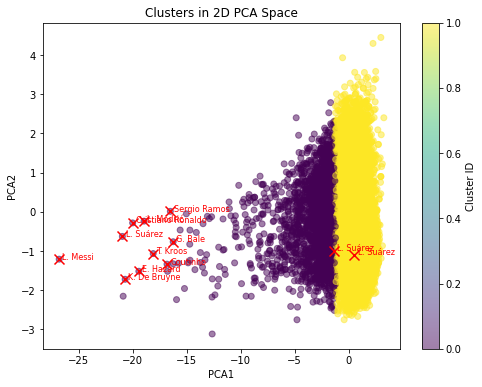

In [15]:
best_k, best_score = find_optimal_clusters(df_fifa, selected_features, min_k=2, max_k=8)
print(f"Optimal k = {best_k}, best Silhouette = {best_score:.4f}")

print("\nCreating a result table for that best k.")
res_df = cluster_and_report_top_10(df_fifa, selected_features, best_k, top_10_players, id_col="Name")
res_df.show()

print("\nApply PCA for 5, 4, 3 principal components & measure Silhouette each time.")
for pc in [5, 4, 3]:
    # Filter out any rows missing those features
    valid_df = df_fifa.na.drop(subset=selected_features)
    _, pipe_output = build_feature_pipeline(valid_df, selected_features, best_k)
    # Now pipe_output has 'scaledFeatures'
    pca_output = apply_pca(pipe_output, "scaledFeatures", "pcaFeatures", pc)
    # Re-run KMeans on pcaFeatures
    kmeans = KMeans(k=best_k, featuresCol="pcaFeatures", predictionCol="pcaClusterPrediction", seed=42)
    kmodel = kmeans.fit(pca_output)
    final_clust = kmodel.transform(pca_output)

    evaluator = ClusteringEvaluator(
        predictionCol="pcaClusterPrediction",
        featuresCol="pcaFeatures",
        metricName="silhouette"
    )
    sil_score = evaluator.evaluate(final_clust)
    print(f"With {pc} PCA components, Silhouette = {sil_score:.4f}")

print("\nFinally, reduce to 2 PCA components and plot the clusters.")
valid_df = df_fifa.na.drop(subset=selected_features)
_, pipe_output = build_feature_pipeline(valid_df, selected_features, best_k)
pca_2d = apply_pca(pipe_output, "scaledFeatures", "pcaFeatures", 2)

km2d = KMeans(k=best_k, featuresCol="pcaFeatures", predictionCol="pcaClusterPrediction", seed=42)
km2d_model = km2d.fit(pca_2d)
pca_2d_final = km2d_model.transform(pca_2d)

plot_2d_clusters(
    pca_2d_final,
    x_col="pcaFeatures",
    cluster_col="pcaClusterPrediction",
    top_10_ids=top_10_players,
    id_col="Name"
)

spark.stop()
